# The Dataset

https://github.com/apacha/MusicSymbolClassifier


Download the Dataset

In [ ]:
! pip install omrdatasettools

     |████████████████████████████████| 42 kB 651 kB/s 
     |████████████████████████████████| 105 kB 8.5 MB/s 
     |████████████████████████████████| 112 kB 39.5 MB/s 
  Created wheel for omrdatasettools: filename=omrdatasettools-1.3.1-py3-none-any.whl size=40702 sha256=073377ea5849367e7b5ecac459844a1109ff7c7ff4e9ad0dad94f2db9451ffc3
  Stored in directory: /root/.cache/pip/wheels/b9/16/bc/a845a04b4ec02f9b7dec53bc842aef736721f750d7b1306e8b
  Created wheel for mung: filename=mung-1.1-py3-none-any.whl size=122605 sha256=41982898ecda7eb3468d5dcdf8057c2fc0dab4f853cde102ead07bfc4e3511e5
  Stored in directory: /root/.cache/pip/wheels/35/c2/c2/1cc7611e63ac003c3e2ce5147e25dd9bcbc1b4480909a3fbe6
  Created wheel for muscima: filename=muscima-0.10.0-py3-none-any.whl size=116528 sha256=676b8288feb81b508cf6ac418d117e6004d0ca5d7cea8ea5ac31c55898fa3404
  Stored in directory: /root/.cache/pip/wheels/68/74/ab/ffb38aed8fdbee6a7fd00e439d33e80815c5ecc52953bcb092
Successfully built omrdatasettools mung m

In [ ]:
from omrdatasettools import Downloader, OmrDataset

downloader = Downloader()
downloader.download_and_extract_dataset(OmrDataset.Rebelo1, "dataset")
downloader.download_and_extract_dataset(OmrDataset.Rebelo2, "dataset")

Downloading: https://github.com/apacha/OMR-Datasets/releases/download/datasets/Rebelo-Music-Symbol-Dataset1.zip Bytes: 2762705 into /content/Rebelo-Music-Symbol-Dataset1.zip



Extracting Rebelo1 dataset...


Downloading: https://github.com/apacha/OMR-Datasets/releases/download/datasets/Rebelo-Music-Symbol-Dataset2.zip Bytes: 3651514 into /content/Rebelo-Music-Symbol-Dataset2.zip



Extracting Rebelo2 dataset...


# Non CNN Approach

In [ ]:
import cv2
import random
import imutils
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# The Image Dimensions and Path of the Training Data
dataset_path = 'train_data/data'
target_img_size = (100, 100)
sample_count = 50

### Feature Extraction

In [ ]:
# Extract the pixels from the image by flattening the image. Ex:- (100, 100, 3) => (30000, )
def extract_raw_pixels(img):
    resized = cv2.resize(img, target_img_size)
    return resized.flatten()

In [ ]:
# Obtain the HSV Histogram from the Music Sheet Image
def extract_hsv_histogram(img):
    resized = cv2.resize(img, target_img_size)
    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist)
    return hist.flatten()

In [ ]:
# Extract the Hog Features from the Image
def extract_hog_features(img):
    img = cv2.resize(img, target_img_size)
    win_size = (100, 100)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)

    block_size = (block_size_in_cells[1] * cell_size[1],
                  block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size,
                            block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [ ]:
# Extract Features from the Image. This function in turn uses one of the following: Raw (Pixels Only), HSV Histogram or HOG Features (Histogram of Oriented Gradients)
def extract_features(img, feature_set='raw'):
    if feature_set == 'hog':
        return extract_hog_features(img)
    elif feature_set == 'raw':
        return extract_raw_pixels(img)
    else:
        return extract_hsv_histogram(img)

### Load Dataset

In [ ]:
# Load the dataset to train and build the model.
def load_dataset(feature_set='raw', dir_names=[]):
    features = []
    labels = []
    count = 0
    for dir_name in dir_names:
        print(dir_name)
        imgs = glob(f'{dataset_path}/{dir_name}/*.png')
        count += len(imgs)
        subset = random.sample([i for i in range(len(imgs))], min(len(imgs), sample_count))
        for i in subset:
            img = cv2.imread(imgs[i])
            labels.append(dir_name)
            features.append(extract_features(img, feature_set))
    print(f'Total: {len(dir_names)} directories, and {count} images')
    return features, labels

### Model Building

In [ ]:
# Load the Classifiers that can be used to build the model
# The following classifiers were experimented with:
# 1. Support Vector Machine
# 2. K-Nearest Neighbor
# 3. Multi Layer Perceptron - NN
def load_classifiers():
    random_seed = 42
    random.seed(random_seed)
    np.random.seed(random_seed)

    classifiers = {
        'SVM': svm.LinearSVC(random_state=random_seed),
        'KNN': KNeighborsClassifier(n_neighbors=7),
        'NN': MLPClassifier(activation='relu', hidden_layer_sizes=(200,),
                            max_iter=10000, alpha=1e-4,
                            solver='adam', verbose=20,
                            tol=1e-8, random_state=1,
                            learning_rate_init=.0001,
                            learning_rate='adaptive')
    }
    return classifiers, random_seed

In [ ]:
# Run Experiment(s) to build model using the chosen classifiers
def run_experiment(classifier='SVM', feature_set='hog', dir_names=[]):
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset(feature_set, dir_names)
    print('Finished loading dataset.')

    classifiers, random_seed = load_classifiers()

    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)

    model = classifiers[classifier]
    print('############## Training', classifier, "##############")
    model.fit(train_features, train_labels)
    accuracy = model.score(test_features, test_labels)
    print(classifier, 'accuracy:', accuracy*100, '%')

    return model, accuracy

In [ ]:
# Method to initiate the model training
def train(model_name, feature_name, saved_model_name):
    dir_names = [path.split('/')[2] for path in glob(f'{dataset_path}/*')]

    model, accuracy = run_experiment(model_name, feature_name, dir_names)

    filename = f'trained_models/{saved_model_name}.sav'
    pickle.dump(model, open(filename, 'wb'))


if __name__ == "__main__":
    train('NN', 'hog', 'nn_trained_model_hog')

# Convolutional Neural Network Approach

In [ ]:
# CNN Training Approach using Keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from glob import glob
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The Image Dimensions and Path of the Training Data
dataset_path = 'dataset'
target_img_size = (32, 32)
# sample_count = 50

### Load Dataset

In [ ]:
# Load Images for CNN Building
dir_names=[]
for path in glob(f'{dataset_path}/*'):
  dir_names.append(path.split('/')[1])

labels=[]
images=[]

for dir_name in dir_names:
  print(dir_name)

  imgs = glob(f'{dataset_path}/{dir_name}/*.png')
  # count += len(imgs)
  # subset = random.sample([i for i in range(len(imgs))], min(len(imgs), sample_count))
  for img in imgs:
    img = cv2.imread(img)
    img = cv2.resize(img, target_img_size, interpolation = cv2.INTER_AREA)
    labels.append(dir_name)
    images.append(img)

Thirty-Two-Rest
Sixteenth-Note
Dot
Cut-Time
Quarter-Note
Stopped
Fermata
4-8-Time
7-4-Time
Sharp
Whole-Half-Rest
9-8-Time
Thirty-Two-Note
8-8-Time
2-4-Time
Staccatissimo
C-Clef
G-Clef
Turn
Half-Note
12-8-Time
Double-Whole-Rest
Quarter-Rest
Multiple-Quarter-Notes
Other
Eighth-Rest
6-4-Time
Chord
5-8-Time
Tie-Slur
Whole-Note
4-2-Time
2-8-Time
Mordent
Flat
Eighth-Note
Natural
Barline
3-4-Time
Accent
Tenuto
Tuplet
Eighth-Grace-Note
Glissando
Common-Time
5-4-Time
Multiple-Half-Notes
F-Clef
Sixteenth-Rest
Multiple-Sixteenth-Notes
Beam
4-4-Time
3-8-Time
Multiple-Eighth-Notes
Sixty-Four-Note
6-8-Time
Sixty-Four-Rest
Marcato
Breve
1-8-Time


In [ ]:
# Print Statistics Per Class
from collections import Counter
print(Counter(labels).keys()) # equals to list(set(words))
print(Counter(labels).values()) # counts the elements' frequency
print(len(Counter(labels).keys()))

dict_keys(['Thirty-Two-Rest', 'Sixteenth-Note', 'Dot', 'Cut-Time', 'Quarter-Note', 'Stopped', 'Fermata', '4-8-Time', '7-4-Time', 'Sharp', 'Whole-Half-Rest', '9-8-Time', 'Thirty-Two-Note', '8-8-Time', '2-4-Time', 'Staccatissimo', 'C-Clef', 'G-Clef', 'Turn', 'Half-Note', '12-8-Time', 'Double-Whole-Rest', 'Quarter-Rest', 'Multiple-Quarter-Notes', 'Other', 'Eighth-Rest', '6-4-Time', 'Chord', '5-8-Time', 'Tie-Slur', 'Whole-Note', '4-2-Time', '2-8-Time', 'Mordent', 'Flat', 'Eighth-Note', 'Natural', 'Barline', '3-4-Time', 'Accent', 'Tenuto', 'Tuplet', 'Eighth-Grace-Note', 'Glissando', 'Common-Time', '5-4-Time', 'Multiple-Half-Notes', 'F-Clef', 'Sixteenth-Rest', 'Multiple-Sixteenth-Notes', 'Beam', '4-4-Time', '3-8-Time', 'Multiple-Eighth-Notes', 'Sixty-Four-Note', '6-8-Time', 'Sixty-Four-Rest', 'Marcato', 'Breve', '1-8-Time'])
dict_values([227, 42, 440, 228, 913, 85, 102, 1, 9, 1193, 123, 5, 142, 6, 40, 116, 339, 810, 81, 673, 2, 106, 589, 243, 802, 705, 4, 118, 13, 466, 275, 6, 12, 86, 972, 4

In [ ]:
# One Hot Encode Labels
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(labels)
print(transfomed_label)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [ ]:
print(encoder.inverse_transform(transfomed_label))

['Thirty-Two-Rest' 'Thirty-Two-Rest' 'Thirty-Two-Rest' ... 'Breve'
 '1-8-Time' '1-8-Time']


In [ ]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(images, transfomed_label, test_size=0.2, random_state=42)

In [ ]:
# Convert the Train and test into Numpy Arrays
X_train=np.asarray(X_train).astype('float32')
X_test=np.asarray(X_test).astype('float32')
# y_train=np.asarray(y_train).astype('float32')
# y_test=np.asarray(y_test).astype('float32')

In [ ]:
# Scale Images Between 0 and 1 (Standardization)
X_train=X_train/255.0
X_test=X_test/255.0

### Model Building

#### VGG16

In [ ]:
# VGG16 with pretrained weights
vgg16 = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(32,32,3))
# add a global spatial average pooling layer
x = vgg16.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x) 
# and a fully connected output/classification layer
predictions = tf.keras.layers.Dense(60, activation='softmax')(x)
# create the full network so we can train on it
vgg16 = Model(inputs=vgg16.input, outputs=predictions)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# VGG16
vgg16.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Train VGG16
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

with tf.device("/device:GPU:0"):
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  
  vgg16_history_pretrained = vgg16.fit(X_train, y_train, epochs=10, shuffle = True, callbacks=[reduce_lr_loss], verbose = 1, validation_split=0.2)

Epoch 1/10
304/304 [==============================] - 33s 70ms/step - loss: 1.6147 - accuracy: 0.6251 - val_loss: 0.4132 - val_accuracy: 0.8905 - lr: 1.0000e-04
Epoch 2/10
304/304 [==============================] - 20s 65ms/step - loss: 0.3040 - accuracy: 0.9160 - val_loss: 0.2388 - val_accuracy: 0.9342 - lr: 1.0000e-04
Epoch 3/10
304/304 [==============================] - 20s 65ms/step - loss: 0.1838 - accuracy: 0.9471 - val_loss: 0.1786 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 4/10
304/304 [==============================] - 20s 65ms/step - loss: 0.1251 - accuracy: 0.9612 - val_loss: 0.1486 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 5/10
304/304 [==============================] - 20s 65ms/step - loss: 0.0982 - accuracy: 0.9711 - val_loss: 0.1549 - val_accuracy: 0.9564 - lr: 1.0000e-04
Epoch 6/10
304/304 [==============================] - 21s 68ms/step - loss: 0.0747 - accuracy: 0.9769 - val_loss: 0.1380 - val_accuracy: 0.9621 - lr: 1.0000e-04
Epoch 7/10
304/304 [==============

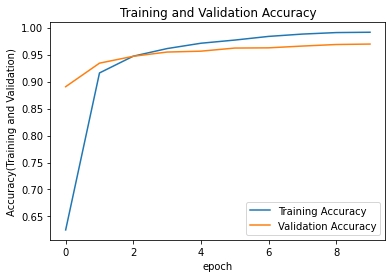

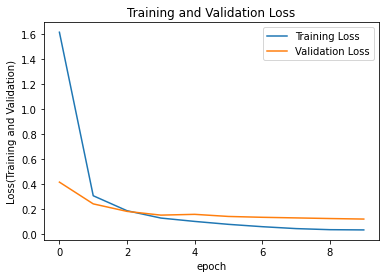

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(vgg16_history_pretrained.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy(Training and Validation)')
plt.xlabel('epoch')
plt.legend(loc='lower right')
#plt.legend(['Training'],['Validation'], loc='upper left')
plt.title('Training and Validation Accuracy')

#plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg16_history_pretrained.history['loss'], label='Training Loss')
plt.plot(vgg16_history_pretrained.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss(Training and Validation)')
plt.xlabel('epoch')
#plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.legend(loc='upper right')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Training, Validation Accuracy and Loss
import statistics
#data = [accuracy']
x = statistics.mean(vgg16_history_pretrained.history['accuracy'])
print("Training Accuracy: ", x)

y = statistics.mean(vgg16_history_pretrained.history['loss'])
print("Training Loss: ", y)

x1 = statistics.mean(vgg16_history_pretrained.history['val_accuracy'])
print("Validation Accuracy: ",x1)

y1 = statistics.mean(vgg16_history_pretrained.history['val_loss'])
print("Validation Loss: ",y1)

Training Accuracy:  0.9351482152938843
Training Loss:  0.25591110810637474
Validation Accuracy:  0.9511522591114044
Validation Loss:  0.17682373523712158


In [ ]:
train_predictions = vgg16.predict(X_train)
test_predictions = vgg16.predict(X_test)

print("Train Data: "+str(accuracy_score(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1))))
print("Test Data: "+str(accuracy_score(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1))))
# Train Data Classification Report
print(classification_report(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1)))
# Test Data Classification Report
print(classification_report(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1)))

Train Data: 0.9905318623415116
Test Data: 0.9637800460981232
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.50      0.67         2
           2       0.86      0.97      0.91        32
           3       1.00      0.50      0.67        10
           4       0.97      0.96      0.96        69
           5       1.00      0.90      0.95        21
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00         1
           9       1.00      0.70      0.82        10
          10       0.75      1.00      0.86        12
          11       1.00      1.00      1.00         4
          12       0.72      1.00      0.84        13
          13       1.00      1.00      1.00         8
          14       1.00      0.50      0.67         6
          15       0.80      1.00      0.89         4
          16       1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
vgg16.save("VGG16_Model.h5")

#### VGG19

In [ ]:
# VGG19 with pretrained weights
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False,input_shape=(32,32,3))
# add a global spatial average pooling layer
x = vgg19.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = tf.keras.layers.Dense(60, activation='softmax')(x)
# create the full network so we can train on it
vgg19 = Model(inputs=vgg19.input, outputs=predictions)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# VGG19
vgg19.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

with tf.device("/device:GPU:0"):
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  
  vgg19_history_pretrained = vgg19.fit(X_train, y_train, epochs=10, shuffle = True, callbacks=[reduce_lr_loss, earlyStopping, model_checkpoint_callback], verbose = 1, validation_split=0.2)

Epoch 1/10
304/304 [==============================] - 27s 84ms/step - loss: 1.3998 - accuracy: 0.6749 - val_loss: 0.4318 - val_accuracy: 0.8807 - lr: 1.0000e-04
Epoch 2/10
304/304 [==============================] - 25s 82ms/step - loss: 0.3095 - accuracy: 0.9131 - val_loss: 0.2344 - val_accuracy: 0.9309 - lr: 1.0000e-04
Epoch 3/10
304/304 [==============================] - 25s 82ms/step - loss: 0.1933 - accuracy: 0.9460 - val_loss: 0.1764 - val_accuracy: 0.9481 - lr: 1.0000e-04
Epoch 4/10
304/304 [==============================] - 24s 80ms/step - loss: 0.1289 - accuracy: 0.9619 - val_loss: 0.1909 - val_accuracy: 0.9440 - lr: 1.0000e-04
Epoch 5/10
304/304 [==============================] - 24s 80ms/step - loss: 0.0905 - accuracy: 0.9725 - val_loss: 0.1274 - val_accuracy: 0.9687 - lr: 1.0000e-04
Epoch 6/10
304/304 [==============================] - 24s 80ms/step - loss: 0.0705 - accuracy: 0.9787 - val_loss: 0.1149 - val_accuracy: 0.9720 - lr: 1.0000e-04
Epoch 7/10
304/304 [==============

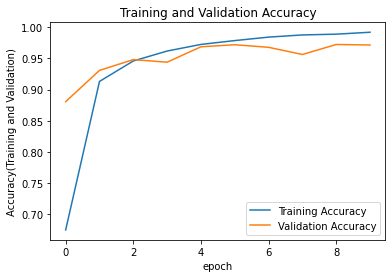

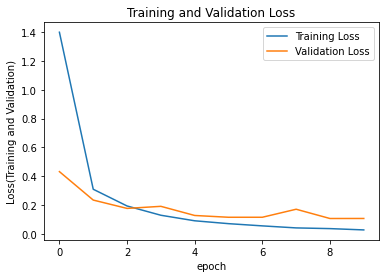

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(vgg19_history_pretrained.history['accuracy'], label='Training Accuracy')
plt.plot(vgg19_history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy(Training and Validation)')
plt.xlabel('epoch')
plt.legend(loc='lower right')
#plt.legend(['Training'],['Validation'], loc='upper left')
plt.title('Training and Validation Accuracy')

#plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg19_history_pretrained.history['loss'], label='Training Loss')
plt.plot(vgg19_history_pretrained.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss(Training and Validation)')
plt.xlabel('epoch')
#plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.legend(loc='upper right')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Training, Validation Accuracy and Loss
import statistics
#data = [accuracy']
x = statistics.mean(vgg19_history_pretrained.history['accuracy'])
print("Training Accuracy: ", x)

y = statistics.mean(vgg19_history_pretrained.history['loss'])
print("Training Loss: ", y)

x1 = statistics.mean(vgg19_history_pretrained.history['val_accuracy'])
print("Validation Accuracy: ",x1)

y1 = statistics.mean(vgg19_history_pretrained.history['val_loss'])
print("Validation Loss: ",y1)

Training Accuracy:  0.9400164604187011
Training Loss:  0.2351911924779415
Validation Accuracy:  0.9512757122516632
Validation Loss:  0.17743507400155067


In [ ]:
train_predictions = vgg19.predict(X_train)
test_predictions = vgg19.predict(X_test)

print("Train Data: "+str(accuracy_score(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1))))
print("Test Data: "+str(accuracy_score(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1))))
# Train Data Classification Report
print(classification_report(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1)))
# Test Data Classification Report
print(classification_report(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1)))

Train Data: 0.9916845051868928
Test Data: 0.9720118538030952
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.50      0.67         2
           2       0.94      1.00      0.97        32
           3       0.88      0.70      0.78        10
           4       1.00      0.99      0.99        69
           5       0.83      0.95      0.89        21
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00         1
           9       1.00      0.90      0.95        10
          10       0.92      1.00      0.96        12
          11       1.00      1.00      1.00         4
          12       0.92      0.92      0.92        13
          13       1.00      1.00      1.00         8
          14       0.67      0.67      0.67         6
          15       0.75      0.75      0.75         4
          16       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
vgg19.save("VGG19_Model.h5")

#### ResNet101

In [ ]:
# ResNet101 with pretrained weights
resnet101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(32,32,3))
# add a global spatial average pooling layer
x = resnet101.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = tf.keras.layers.Dense(60, activation='softmax')(x)
# create the full network so we can train on it
resnet101 = Model(inputs=resnet101.input, outputs=predictions)

171458560/171446536 [==============================] - 1s 0us/step


In [ ]:
# ResNet101
resnet101.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

with tf.device("/device:GPU:0"):
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  
  resnet101_history_pretrained = resnet101.fit(X_train, y_train, epochs=10, shuffle = True, callbacks=[reduce_lr_loss, earlyStopping, model_checkpoint_callback], verbose = 1, validation_split=0.2)

Epoch 1/10
304/304 [==============================] - 77s 211ms/step - loss: 2.4398 - accuracy: 0.4546 - val_loss: 50.9296 - val_accuracy: 0.0963 - lr: 1.0000e-04
Epoch 2/10
304/304 [==============================] - 63s 206ms/step - loss: 1.0217 - accuracy: 0.7643 - val_loss: 13.4368 - val_accuracy: 0.0934 - lr: 1.0000e-04
Epoch 3/10
304/304 [==============================] - 61s 200ms/step - loss: 0.6874 - accuracy: 0.8337 - val_loss: 2.6449 - val_accuracy: 0.4218 - lr: 1.0000e-04
Epoch 4/10
304/304 [==============================] - 61s 200ms/step - loss: 0.5979 - accuracy: 0.8554 - val_loss: 1.1581 - val_accuracy: 0.8267 - lr: 1.0000e-04
Epoch 5/10
304/304 [==============================] - 61s 200ms/step - loss: 0.5101 - accuracy: 0.8729 - val_loss: 1.0617 - val_accuracy: 0.7329 - lr: 1.0000e-04
Epoch 6/10
304/304 [==============================] - 62s 205ms/step - loss: 0.4252 - accuracy: 0.8910 - val_loss: 0.5496 - val_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 7/10
304/304 [======

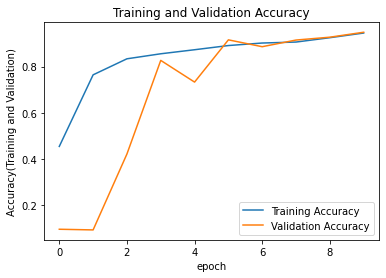

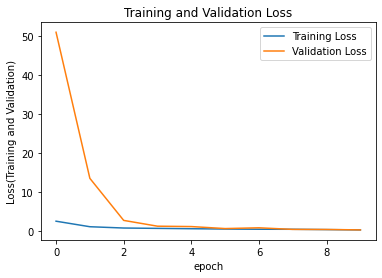

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(resnet101_history_pretrained.history['accuracy'], label='Training Accuracy')
plt.plot(resnet101_history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy(Training and Validation)')
plt.xlabel('epoch')
plt.legend(loc='lower right')
#plt.legend(['Training'],['Validation'], loc='upper left')
plt.title('Training and Validation Accuracy')

#plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resnet101_history_pretrained.history['loss'], label='Training Loss')
plt.plot(resnet101_history_pretrained.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss(Training and Validation)')
plt.xlabel('epoch')
#plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.legend(loc='upper right')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Training, Validation Accuracy and Loss
import statistics
#data = [accuracy']
x = statistics.mean(resnet101_history_pretrained.history['accuracy'])
print("Training Accuracy: ", x)

y = statistics.mean(resnet101_history_pretrained.history['loss'])
print("Training Loss: ", y)

x1 = statistics.mean(resnet101_history_pretrained.history['val_accuracy'])
print("Validation Accuracy: ",x1)

y1 = statistics.mean(resnet101_history_pretrained.history['val_loss'])
print("Validation Loss: ",y1)

Training Accuracy:  0.8350041091442109
Training Loss:  0.6913195624947548
Validation Accuracy:  0.6763374455273151
Validation Loss:  7.138174042105675


In [ ]:
train_predictions = resnet101.predict(X_train)
test_predictions = resnet101.predict(X_test)

print("Train Data: "+str(accuracy_score(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1))))
print("Test Data: "+str(accuracy_score(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1))))
# Train Data Classification Report
print(classification_report(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1)))
# Test Data Classification Report
print(classification_report(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1)))

Train Data: 0.9734068829244196
Test Data: 0.945011524530787
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.74      0.53      0.62        32
           3       0.86      0.60      0.71        10
           4       0.68      1.00      0.81        69
           5       0.64      0.67      0.65        21
           6       0.00      0.00      0.00         3
           7       1.00      0.75      0.86        16
           8       0.00      0.00      0.00         1
           9       1.00      0.10      0.18        10
          10       1.00      0.67      0.80        12
          11       0.00      0.00      0.00         4
          12       0.64      0.54      0.58        13
          13       1.00      0.12      0.22         8
          14       0.40      0.33      0.36         6
          15       0.00      0.00      0.00         4
          16       1.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
resnet101.save("ResNet101_Model.h5")

#### MobileNetV2

In [ ]:
# MobileNetV2 with pretrained weights
mobilenetv2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = mobilenetv2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = tf.keras.layers.Dense(60, activation='softmax')(x)
# create the full network so we can train on it
mobilenetv2 = Model(inputs=mobilenetv2.input, outputs=predictions)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Mobile Net V2
mobilenetv2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

with tf.device("/device:GPU:0"):
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  
  mobilenetv2_history_pretrained = mobilenetv2.fit(X_train, y_train, epochs=10, shuffle = True, callbacks=[reduce_lr_loss, earlyStopping, model_checkpoint_callback], verbose = 1, validation_split=0.2)

Epoch 1/10
304/304 [==============================] - 14s 47ms/step - loss: 1.7735 - accuracy: 0.5866 - val_loss: 4.0369 - val_accuracy: 0.0868 - lr: 1.0000e-04
Epoch 2/10
304/304 [==============================] - 11s 35ms/step - loss: 1.5069 - accuracy: 0.6489 - val_loss: 4.0207 - val_accuracy: 0.1049 - lr: 1.0000e-04
Epoch 3/10
304/304 [==============================] - 11s 35ms/step - loss: 1.2375 - accuracy: 0.7080 - val_loss: 3.9513 - val_accuracy: 0.2033 - lr: 1.0000e-04
Epoch 4/10
304/304 [==============================] - 11s 37ms/step - loss: 1.0384 - accuracy: 0.7505 - val_loss: 3.7837 - val_accuracy: 0.3198 - lr: 1.0000e-04
Epoch 5/10
304/304 [==============================] - 11s 35ms/step - loss: 0.9056 - accuracy: 0.7781 - val_loss: 3.4750 - val_accuracy: 0.5123 - lr: 1.0000e-04
Epoch 6/10
304/304 [==============================] - 11s 37ms/step - loss: 0.7833 - accuracy: 0.8067 - val_loss: 3.0897 - val_accuracy: 0.6885 - lr: 1.0000e-04
Epoch 7/10
304/304 [==============

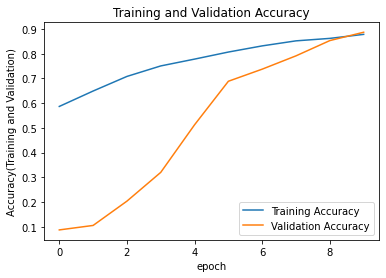

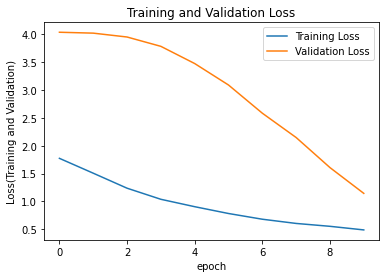

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(mobilenetv2_history_pretrained.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenetv2_history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy(Training and Validation)')
plt.xlabel('epoch')
plt.legend(loc='lower right')
#plt.legend(['Training'],['Validation'], loc='upper left')
plt.title('Training and Validation Accuracy')

#plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mobilenetv2_history_pretrained.history['loss'], label='Training Loss')
plt.plot(mobilenetv2_history_pretrained.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss(Training and Validation)')
plt.xlabel('epoch')
#plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.legend(loc='upper right')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Training, Validation Accuracy and Loss
import statistics
#data = [accuracy']
x = statistics.mean(mobilenetv2_history_pretrained.history['accuracy'])
print("Training Accuracy: ", x)

y = statistics.mean(mobilenetv2_history_pretrained.history['loss'])
print("Training Loss: ", y)

x1 = statistics.mean(mobilenetv2_history_pretrained.history['val_accuracy'])
print("Validation Accuracy: ",x1)

y1 = statistics.mean(mobilenetv2_history_pretrained.history['val_loss'])
print("Validation Loss: ",y1)

Training Accuracy:  0.7702655494213104
Training Loss:  0.957272732257843
Validation Accuracy:  0.5184362135827542
Validation Loss:  2.984019160270691


In [ ]:
train_predictions = mobilenetv2.predict(X_train)
test_predictions = mobilenetv2.predict(X_test)

print("Train Data: "+str(accuracy_score(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1))))
print("Test Data: "+str(accuracy_score(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1))))
# Train Data Classification Report
print(classification_report(y_train.argmax(axis=-1), train_predictions.argmax(axis=-1)))
# Test Data Classification Report
print(classification_report(y_test.argmax(axis=-1), test_predictions.argmax(axis=-1)))

Train Data: 0.9095175366375762
Test Data: 0.8939743167599605
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        10
           4       0.44      0.97      0.60        69
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00         3
           7       0.91      0.62      0.74        16
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         4
          16       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
mobilenetv2.save("MobileNetV2_Model.h5")